## Zadanie polega na zaprognozowanie czy klientowi zostanie wypłacona pożyczka - 'Disbursed'

## Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")
import scikitplot as scikitplot
import scikitplot.plotters as skplt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import category_encoders as ce
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pd.pandas.set_option('display.max_columns', None)
from datetime import date
from datetime import datetime
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import ensemble
import codecs

## Import bazy (wersja z lokalnymi danymi i z bazą z sieci)

In [2]:
# df = pd.read_csv(codecs.open("train.csv", "r",encoding='utf-8', errors='ignore'))
df = pd.read_csv("https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/" \
                   "master/dataSet/Train.csv",sep=",",encoding="latin1")

opis zmiennych ze striny: https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

Input variables:

ID - Unique ID (can not be used for predictions)
Gender- Sex
City - Current City
Monthly_Income - Monthly Income in rupees
DOB - Date of Birth
Lead_Creation_Date - Lead Created on date
Loan_Amount_Applied - Loan Amount Requested (INR)
Loan_Tenure_Applied - Loan Tenure Requested (in years)
Existing_EMI - EMI of Existing Loans (INR)
Employer_Name - Employer Name
Salary_Account- Salary account with Bank
Mobile_Verified - Mobile Verified (Y/N)
Var5- Continuous classified variable
Var1- Categorical variable with multiple levels
Loan_Amount_Submitted- Loan Amount Revised and Selected after seeing Eligibility
Loan_Tenure_Submitted- Loan Tenure Revised and Selected after seeing Eligibility (Years)
Interest_Rate- Interest Rate of Submitted Loan Amount
Processing_Fee- Processing Fee of Submitted Loan Amount (INR)
EMI_Loan_Submitted- EMI of Submitted Loan Amount (INR)
Filled_Form- Filled Application form post quote
Device_Type- Device from which application was made (Browser/ Mobile)
Var2- Categorical Variable with multiple Levels
Source- Categorical Variable with multiple Levels
Var4- Categorical Variable with multiple Levels

Outcomes:

LoggedIn- Application Logged (Variable for understanding the problem – cannot be used in prediction)
Disbursed- Loan Disbursed (Target Variable)

## Kolumny 'ID' oraz LoggedIn' zostają usunięte z bazy (numer klienta, informacja o targecie)

In [3]:
df = df.drop(["ID","LoggedIn"], axis=1)

## Usuniecie kolumn VAR brak informacji o zawartosci

In [4]:
# kolumny 'VAR' zostają usunięte z bazy nie znane znaczenie biznesowe
df = df.drop(["Var1","Var2","Var4","Var5"], axis=1)

## Zmiana nazwy zmiennej celu

In [5]:
#zmiana nazwy zmiennej celu na target
df = df.rename(columns={"Disbursed": "target"})
df.head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target
0,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,NaN,NaN,NaN,NaN,NaN,N,Web-browser,S122,0
1,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,S122,0
2,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,S143,0
3,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,State Bank of India,Y,920000.0,5.0,NaN,NaN,NaN,N,Web-browser,S143,0
4,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,500000.0,2.0,NaN,NaN,NaN,N,Web-browser,S134,0


## Kod do generowania podstawowych informacji o bazie

In [6]:
def podstawowe_informacje_z_bazy(df):
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Wymiar bazy:")
    print("------------------------------------------------------------------------------------------------------\n")
    print("{} wierszy {} kolumn\n".format(df.shape[0], df.shape[1]))
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Pierwsze 3 rekordy z bazy:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.head(3))
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Ostatnie 3 rekordy z bazy:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.tail(3))
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Kolumny w bazie:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.columns.tolist())
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Podstawowe informacje z danych:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.info())
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Podstawowe agregaty na danych numerycznych z bazy:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.describe())
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Podstawowe agregaty na wszystkich danych z bazy:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.describe(include="all"))
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Liczba brakow danych w kolumnach:")
    print("------------------------------------------------------------------------------------------------------")
    display(df.isnull().sum())
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")
    print("Poziom zmiennej celu (target):")
    print("------------------------------------------------------------------------------------------------------")
    try:
        display(df.target.value_counts(normalize=True))
    except:
        print('')
    print("------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------")

## Drukowanie podstawowych informacji o bazie

In [7]:
podstawowe_informacje_z_bazy(df)

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Wymiar bazy:
------------------------------------------------------------------------------------------------------

87020 wierszy 20 kolumn

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Pierwsze 3 rekordy z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target
0,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,NaN,NaN,NaN,NaN,NaN,N,Web-browser,S122,0
1,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,S122,0
2,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,S143,0


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Ostatnie 3 rekordy z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target
87017,Male,Bengaluru,118000,28-Jan-72,31-Jul-15,0.0,0.0,0.0,BANGALORE INSTITUTE OF TECHNOLOGY,Syndicate Bank,Y,1200000.0,4.0,NaN,NaN,NaN,N,Mobile,S122,0
87018,Male,Bengaluru,98930,27-Apr-77,31-Jul-15,800000.0,5.0,13660.0,FIRSTSOURCE SOLUTION LTD,ICICI Bank,Y,800000.0,5.0,NaN,NaN,NaN,N,Web-browser,S122,0
87019,Male,Mumbai,42300,31-Oct-88,31-Jul-15,0.0,0.0,0.0,GOVERNMENT OF INDIA,NaN,Y,690000.0,4.0,13.99,3450.0,18851.81,N,Web-browser,S122,0


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Kolumny w bazie:
------------------------------------------------------------------------------------------------------


['Gender',
 'City',
 'Monthly_Income',
 'DOB',
 'Lead_Creation_Date',
 'Loan_Amount_Applied',
 'Loan_Tenure_Applied',
 'Existing_EMI',
 'Employer_Name',
 'Salary_Account',
 'Mobile_Verified',
 'Loan_Amount_Submitted',
 'Loan_Tenure_Submitted',
 'Interest_Rate',
 'Processing_Fee',
 'EMI_Loan_Submitted',
 'Filled_Form',
 'Device_Type',
 'Source',
 'target']

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe informacje z danych:
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 20 columns):
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Loan_Amount_Submitted    52407 

None

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe agregaty na danych numerycznych z bazy:
------------------------------------------------------------------------------------------------------


,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,target
count,8.702000e+04,8.694900e+04,86949.000000,8.694900e+04,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000,87020.000000
mean,5.884997e+04,2.302507e+05,2.131399,3.696228e+03,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377,0.014629
std,2.177511e+06,3.542068e+05,2.014193,3.981021e+04,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050,0.120062
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.000000e+04,1.000000,11.990000,200.000000,1176.410000,0.000000
25%,1.650000e+04,0.000000e+00,0.000000,0.000000e+00,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000,0.000000
50%,2.500000e+04,1.000000e+05,2.000000,0.000000e+00,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000,0.000000
75%,4.000000e+04,3.000000e+05,4.000000,3.500000e+03,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000,0.000000
max,4.445544e+08,1.000000e+07,10.000000,1.000000e+07,3.000000e+06,6.000000,37.000000,50000.000000,144748.280000,1.000000


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe agregaty na wszystkich danych z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target
count,87020,86017,8.702000e+04,87020,87020,8.694900e+04,86949.000000,8.694900e+04,86949,75256,87020,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000,87020,87020,87020,87020.000000
unique,2,697,NaN,11345,92,NaN,NaN,NaN,43567,57,2,NaN,NaN,NaN,NaN,NaN,2,2,30,NaN
top,Male,Delhi,NaN,11-Nov-80,03-Jul-15,NaN,NaN,NaN,0,HDFC Bank,Y,NaN,NaN,NaN,NaN,NaN,N,Web-browser,S122,NaN
freq,49848,12527,NaN,306,2315,NaN,NaN,NaN,4914,17695,56481,NaN,NaN,NaN,NaN,NaN,67530,64316,38567,NaN
mean,NaN,NaN,5.884997e+04,NaN,NaN,2.302507e+05,2.131399,3.696228e+03,NaN,NaN,NaN,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377,NaN,NaN,NaN,0.014629
std,NaN,NaN,2.177511e+06,NaN,NaN,3.542068e+05,2.014193,3.981021e+04,NaN,NaN,NaN,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050,NaN,NaN,NaN,0.120062
min,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,5.000000e+04,1.000000,11.990000,200.000000,1176.410000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,1.650000e+04,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,2.500000e+04,NaN,NaN,1.000000e+05,2.000000,0.000000e+00,NaN,NaN,NaN,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,4.000000e+04,NaN,NaN,3.000000e+05,4.000000,3.500000e+03,NaN,NaN,NaN,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000,NaN,NaN,NaN,0.000000


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Liczba brakow danych w kolumnach:
------------------------------------------------------------------------------------------------------


Gender                       0
City                      1003
Monthly_Income               0
DOB                          0
Lead_Creation_Date           0
Loan_Amount_Applied         71
Loan_Tenure_Applied         71
Existing_EMI                71
Employer_Name               71
Salary_Account           11764
Mobile_Verified              0
Loan_Amount_Submitted    34613
Loan_Tenure_Submitted    34613
Interest_Rate            59294
Processing_Fee           59600
EMI_Loan_Submitted       59294
Filled_Form                  0
Device_Type                  0
Source                       0
target                       0
dtype: int64

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Poziom zmiennej celu (target):
------------------------------------------------------------------------------------------------------


0    0.985371
1    0.014629
Name: target, dtype: float64

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------


## Kod do generowania opisu o liczbie unikalnych/wszystkich wartoscach oraz o typie zmiennej 

In [8]:
def unikalne_wartosci(zmienna):
    print('{} - liczba unikalnych wartosci: {}, liczba wszystkich wartosci: {}, , typ zmiennej: {}\n'.format(zmienna, df[zmienna].nunique(),df[zmienna].count(),df[zmienna].dtype))

In [9]:
for zmienne in df.columns.tolist():
    unikalne_wartosci(zmienne)

Gender - liczba unikalnych wartosci: 2, liczba wszystkich wartosci: 87020, , typ zmiennej: object

City - liczba unikalnych wartosci: 697, liczba wszystkich wartosci: 86017, , typ zmiennej: object

Monthly_Income - liczba unikalnych wartosci: 5825, liczba wszystkich wartosci: 87020, , typ zmiennej: int64

DOB - liczba unikalnych wartosci: 11345, liczba wszystkich wartosci: 87020, , typ zmiennej: object

Lead_Creation_Date - liczba unikalnych wartosci: 92, liczba wszystkich wartosci: 87020, , typ zmiennej: object

Loan_Amount_Applied - liczba unikalnych wartosci: 277, liczba wszystkich wartosci: 86949, , typ zmiennej: float64

Loan_Tenure_Applied - liczba unikalnych wartosci: 11, liczba wszystkich wartosci: 86949, , typ zmiennej: float64

Existing_EMI - liczba unikalnych wartosci: 3753, liczba wszystkich wartosci: 86949, , typ zmiennej: float64

Employer_Name - liczba unikalnych wartosci: 43567, liczba wszystkich wartosci: 86949, , typ zmiennej: object

Salary_Account - liczba unikalnyc

## Zmiana dat na bardziej intuicyjne zmienne

In [10]:
def data_rok(df,zmienna,nowa_zmienna):
    df[zmienna] = pd.to_datetime(df[zmienna], errors='coerce', dayfirst=True)
    today = pd.to_datetime('now')
    df[nowa_zmienna] = (today.year - df[zmienna].dt.year) - ((today.month - df[zmienna].dt.month) <0)
    df[nowa_zmienna] = df[nowa_zmienna].apply(lambda x: np.nan if x < 0 else x)
    df = df.drop([zmienna], axis=1)
    return df

In [11]:
df = data_rok(df,'DOB','wiek')

In [12]:
def data_dzien(df,zmienna,nowa_zmienna):
    df[zmienna] = pd.to_datetime(df[zmienna], errors='coerce', dayfirst=True)
    today = pd.to_datetime('now')
    df[nowa_zmienna] = (today - df[zmienna]).astype('timedelta64[D]').astype(int)
    df[nowa_zmienna] = df[nowa_zmienna].apply(lambda x: np.nan if x < 0 else x)
    df = df.drop([zmienna], axis=1)
    return df

In [13]:
df = data_dzien(df,'Lead_Creation_Date','l_dni_od_LCD')

## Wydzielenie zmiennych objasniajacych i zmiennej objasnianej, w zbiorze zmiennych objasniajacych pozostaje jeszcze zmienna celu bedzie potrzebna do analizy 

In [14]:
X = df  
y = df.target

In [15]:
podstawowe_informacje_z_bazy(X)

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Wymiar bazy:
------------------------------------------------------------------------------------------------------

87020 wierszy 20 kolumn

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Pierwsze 3 rekordy z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target,wiek,l_dni_od_LCD
0,Female,Delhi,20000,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,NaN,NaN,NaN,NaN,NaN,N,Web-browser,S122,0,42.0,1872
1,Male,Mumbai,35000,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,S122,0,34.0,1883
2,Male,Panchkula,22500,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,S143,0,38.0,1868


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Ostatnie 3 rekordy z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target,wiek,l_dni_od_LCD
87017,Male,Bengaluru,118000,0.0,0.0,0.0,BANGALORE INSTITUTE OF TECHNOLOGY,Syndicate Bank,Y,1200000.0,4.0,NaN,NaN,NaN,N,Mobile,S122,0,48.0,1795
87018,Male,Bengaluru,98930,800000.0,5.0,13660.0,FIRSTSOURCE SOLUTION LTD,ICICI Bank,Y,800000.0,5.0,NaN,NaN,NaN,N,Web-browser,S122,0,43.0,1795
87019,Male,Mumbai,42300,0.0,0.0,0.0,GOVERNMENT OF INDIA,NaN,Y,690000.0,4.0,13.99,3450.0,18851.81,N,Web-browser,S122,0,31.0,1795


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Kolumny w bazie:
------------------------------------------------------------------------------------------------------


['Gender',
 'City',
 'Monthly_Income',
 'Loan_Amount_Applied',
 'Loan_Tenure_Applied',
 'Existing_EMI',
 'Employer_Name',
 'Salary_Account',
 'Mobile_Verified',
 'Loan_Amount_Submitted',
 'Loan_Tenure_Submitted',
 'Interest_Rate',
 'Processing_Fee',
 'EMI_Loan_Submitted',
 'Filled_Form',
 'Device_Type',
 'Source',
 'target',
 'wiek',
 'l_dni_od_LCD']

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe informacje z danych:
------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 20 columns):
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            2772

None

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe agregaty na danych numerycznych z bazy:
------------------------------------------------------------------------------------------------------


,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,target,wiek,l_dni_od_LCD
count,8.702000e+04,8.694900e+04,86949.000000,8.694900e+04,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000,87020.000000,82604.000000,87020.000000
mean,5.884997e+04,2.302507e+05,2.131399,3.696228e+03,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377,0.014629,34.317878,1838.140876
std,2.177511e+06,3.542068e+05,2.014193,3.981021e+04,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050,0.120062,5.329463,26.919652
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.000000e+04,1.000000,11.990000,200.000000,1176.410000,0.000000,4.000000,1795.000000
25%,1.650000e+04,0.000000e+00,0.000000,0.000000e+00,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000,0.000000,30.000000,1815.000000
50%,2.500000e+04,1.000000e+05,2.000000,0.000000e+00,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000,0.000000,33.000000,1837.000000
75%,4.000000e+04,3.000000e+05,4.000000,3.500000e+03,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000,0.000000,37.000000,1861.000000
max,4.445544e+08,1.000000e+07,10.000000,1.000000e+07,3.000000e+06,6.000000,37.000000,50000.000000,144748.280000,1.000000,50.000000,1886.000000


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Podstawowe agregaty na wszystkich danych z bazy:
------------------------------------------------------------------------------------------------------


,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Source,target,wiek,l_dni_od_LCD
count,87020,86017,8.702000e+04,8.694900e+04,86949.000000,8.694900e+04,86949,75256,87020,5.240700e+04,52407.000000,27726.000000,27420.000000,27726.000000,87020,87020,87020,87020.000000,82604.000000,87020.000000
unique,2,697,NaN,NaN,NaN,NaN,43567,57,2,NaN,NaN,NaN,NaN,NaN,2,2,30,NaN,NaN,NaN
top,Male,Delhi,NaN,NaN,NaN,NaN,0,HDFC Bank,Y,NaN,NaN,NaN,NaN,NaN,N,Web-browser,S122,NaN,NaN,NaN
freq,49848,12527,NaN,NaN,NaN,NaN,4914,17695,56481,NaN,NaN,NaN,NaN,NaN,67530,64316,38567,NaN,NaN,NaN
mean,NaN,NaN,5.884997e+04,2.302507e+05,2.131399,3.696228e+03,NaN,NaN,NaN,3.950106e+05,3.891369,19.197474,5131.150839,10999.528377,NaN,NaN,NaN,0.014629,34.317878,1838.140876
std,NaN,NaN,2.177511e+06,3.542068e+05,2.014193,3.981021e+04,NaN,NaN,NaN,3.082481e+05,1.165359,5.834213,4725.837644,7512.323050,NaN,NaN,NaN,0.120062,5.329463,26.919652
min,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,5.000000e+04,1.000000,11.990000,200.000000,1176.410000,NaN,NaN,NaN,0.000000,4.000000,1795.000000
25%,NaN,NaN,1.650000e+04,0.000000e+00,0.000000,0.000000e+00,NaN,NaN,NaN,2.000000e+05,3.000000,15.250000,2000.000000,6491.600000,NaN,NaN,NaN,0.000000,30.000000,1815.000000
50%,NaN,NaN,2.500000e+04,1.000000e+05,2.000000,0.000000e+00,NaN,NaN,NaN,3.000000e+05,4.000000,18.000000,4000.000000,9392.970000,NaN,NaN,NaN,0.000000,33.000000,1837.000000
75%,NaN,NaN,4.000000e+04,3.000000e+05,4.000000,3.500000e+03,NaN,NaN,NaN,5.000000e+05,5.000000,20.000000,6250.000000,12919.040000,NaN,NaN,NaN,0.000000,37.000000,1861.000000


------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Liczba brakow danych w kolumnach:
------------------------------------------------------------------------------------------------------


Gender                       0
City                      1003
Monthly_Income               0
Loan_Amount_Applied         71
Loan_Tenure_Applied         71
Existing_EMI                71
Employer_Name               71
Salary_Account           11764
Mobile_Verified              0
Loan_Amount_Submitted    34613
Loan_Tenure_Submitted    34613
Interest_Rate            59294
Processing_Fee           59600
EMI_Loan_Submitted       59294
Filled_Form                  0
Device_Type                  0
Source                       0
target                       0
wiek                      4416
l_dni_od_LCD                 0
dtype: int64

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Poziom zmiennej celu (target):
------------------------------------------------------------------------------------------------------


0    0.985371
1    0.014629
Name: target, dtype: float64

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------


## Wykres powiazan miedzy zmiennymi

<Figure size 3600x3600 with 0 Axes>

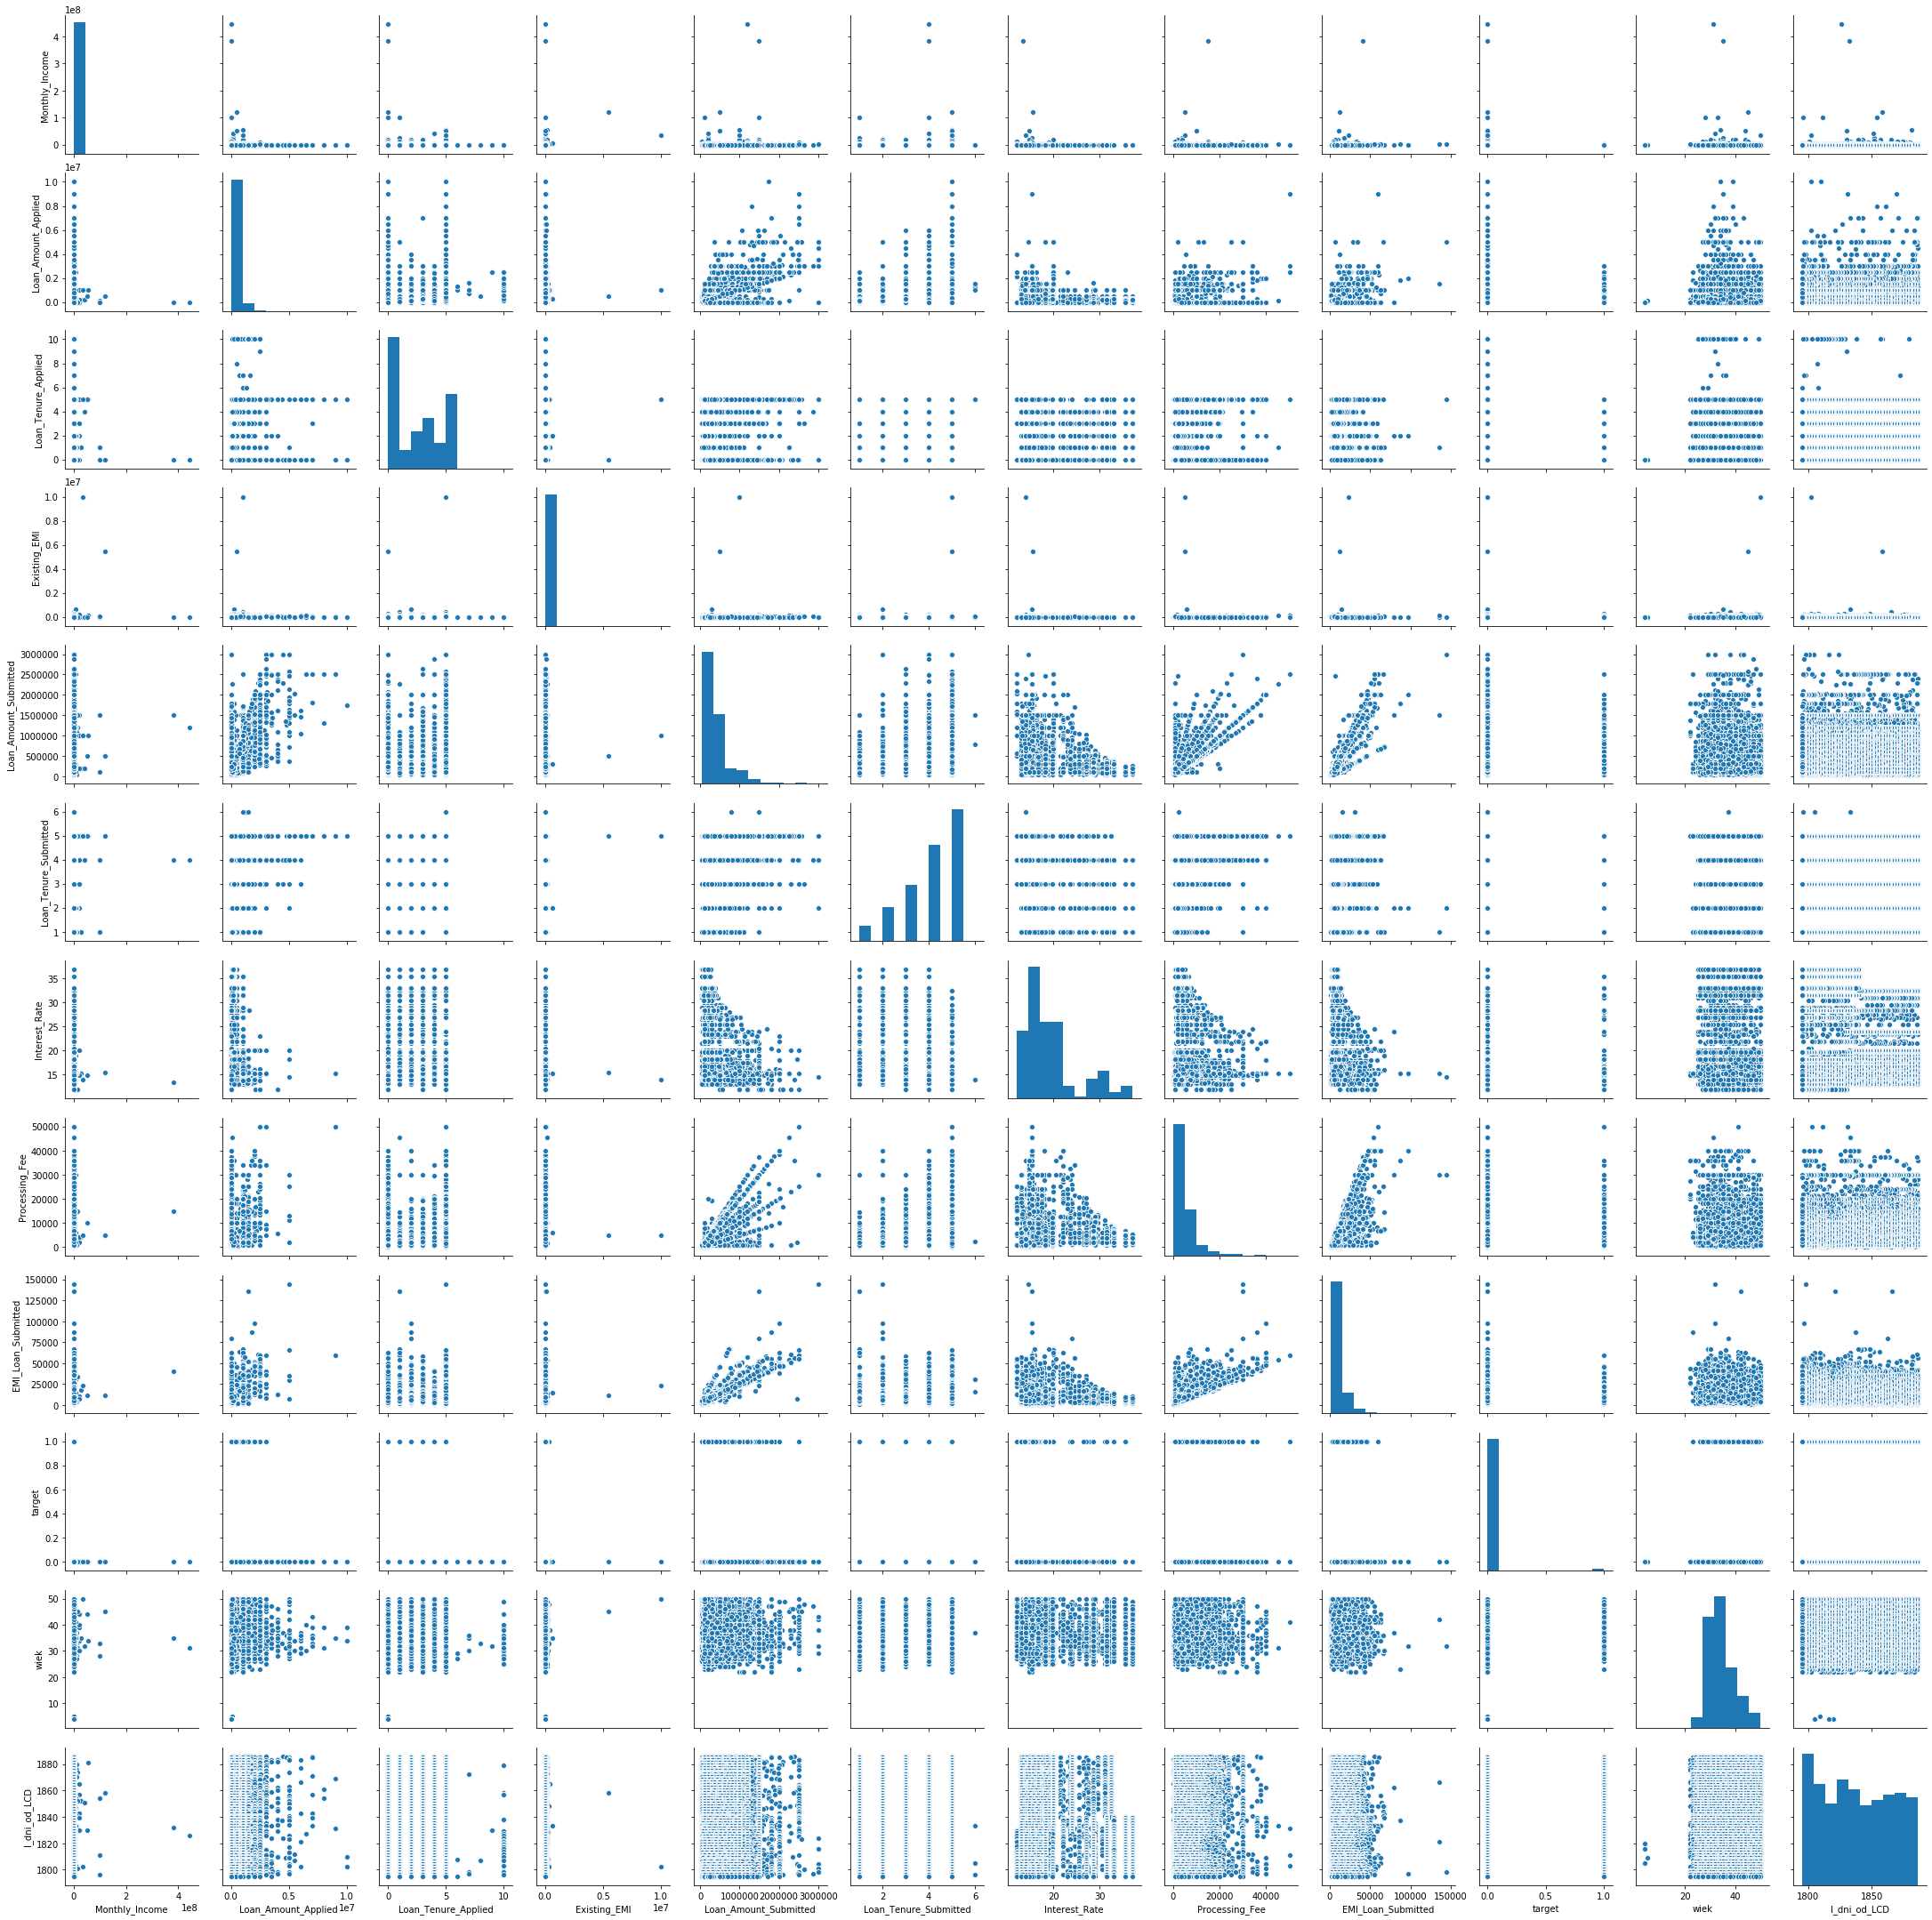

In [16]:
plt.figure(figsize=(50,50));
sns.pairplot(X);

## Histogram dla zmiennych nie numerycznych

In [17]:
def histogram_nie_numeryczne(zmienna):
    plt.style.use('ggplot')
    X.groupby([zmienna,'target']).target.count().unstack().plot.bar(stacked=True, legend=True)
    plt.show()

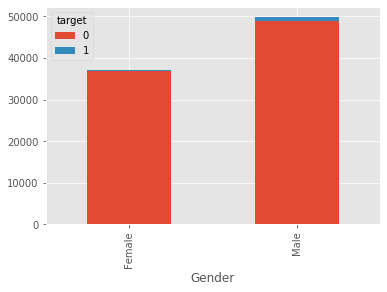

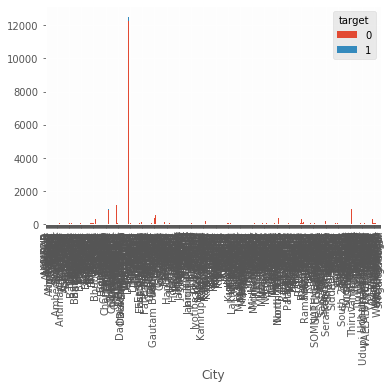

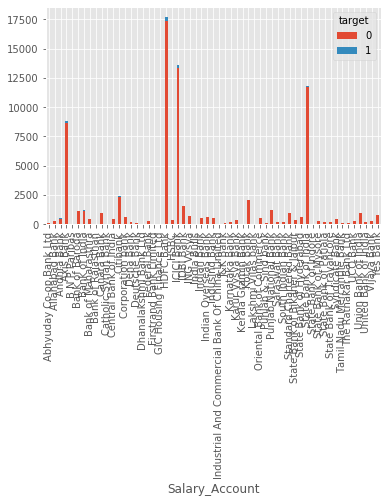

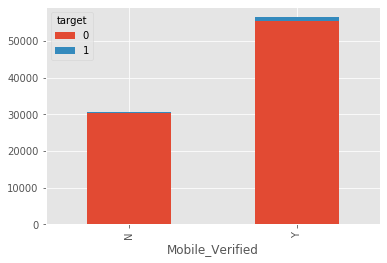

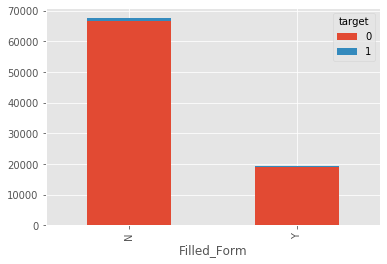

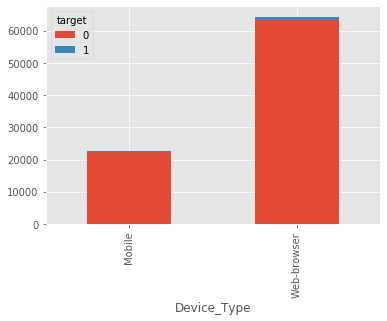

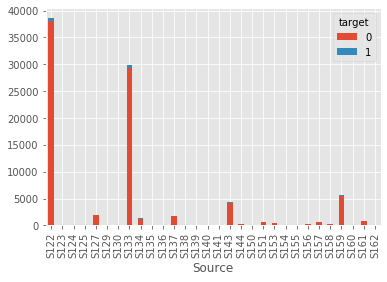

In [18]:
zmienne_do_badania=[
'Gender',                
'City',                                  
'Salary_Account',           
'Mobile_Verified',                      
'Filled_Form',                
'Device_Type',                                      
'Source',
]
for zmienne in zmienne_do_badania:
    histogram_nie_numeryczne(zmienne)

In [19]:
# Analiza zmiennej Employer_Name
Employer_Name = df[['Employer_Name','target']]
Employer_Name.groupby('Employer_Name')['target'].agg(['count','sum','mean']).sort_values(by = ['count'])

,count,sum,mean
Employer_Name,,,
,1,0,0.000000
P.SURESH,1,0,0.000000
P.THALAMUTHU,1,0,0.000000
P.THIRUMURUGAN,1,0,0.000000
P.U.V.RAO,1,0,0.000000
...,...,...,...
GOOGLE,301,0,0.000000
ACCENTURE SERVICES PVT LTD,324,12,0.037037
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,404,10,0.024752


In [20]:
# Analiza zmiennej City
City = df[['City','target']]
City.groupby('City')['target'].agg(['count','sum','mean']).sort_values(by = ['count'])

,count,sum,mean
City,,,
DWARKA,1,0,0.000000
Fazilka,1,0,0.000000
Seoni,1,0,0.000000
GANDEVI,1,0,0.000000
Mokokchung,1,0,0.000000
...,...,...,...
Chennai,6916,67,0.009688
Hyderabad,7272,84,0.011551
Mumbai,10795,169,0.015655


zmienna "City" ma duze licznosci dla pojedynczych kategorii oraz dosyc wysoki udział targetu=1 wiec zmienna pozostaje

eliminacja zmiennej "Employer_Name" duza zmiennosc, mala licznosc dla pojedynczej kategorii bez znaczacego udzialu targetu

In [21]:
X = X.drop(["Employer_Name"], axis=1)

## Korelacja liniowa pearsona miedzy zmiennymi

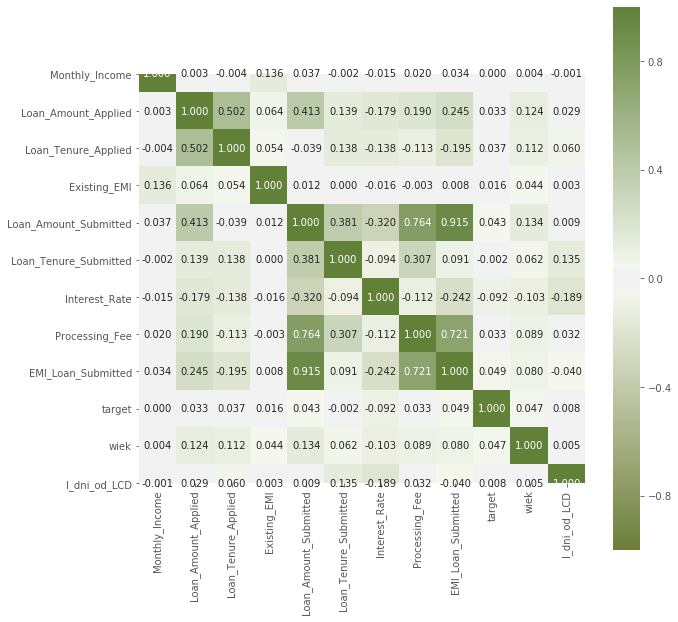

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(
    X.corr(method='pearson'), 
    vmax=1,
    vmin=-1,
    annot=True,
    square=True,
    cmap = sns.diverging_palette(100, 110, as_cmap=True),
    fmt='.3f'
);

## Korelacja spearmana miedzy zmiennymi - uwydatnienie zwiazku nie liniowego

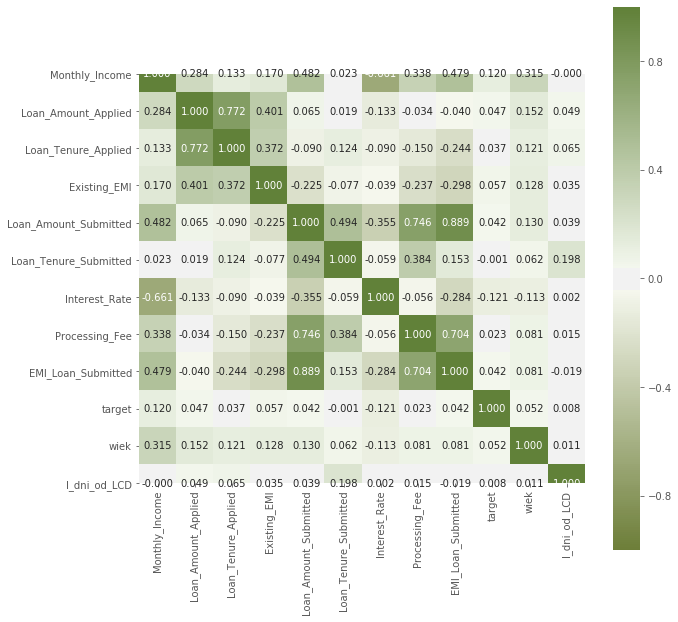

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(
    X.corr(method='spearman'), 
    vmax=1,
    vmin=-1,
    annot=True,
    square=True,
    cmap = sns.diverging_palette(100, 110, as_cmap=True),
    fmt='.3f'
);

dosyc silna korelacja miedzy zmienna target a 
- Monthly_Income wplyw dodati (spearman - zwiazek nieliniowy)
- wiek wplyw dodatki (spearman - zwiazek nieliniowy)
- Interest_Rate wplyw ujemny (spearman - zwiazek nieliniowy)

pozostale zmienne posiadaja slabszy zwiazek liniowy pearsona ale nie odbiega bardzo od korelacji spearmana

przy pierwszym podejsciu aby wychwycic te zwiazki zmienne zostana skategoryzowane i przeksztalcone na zmienne binarne

## Kod do zamiana zmiennych kategorycznych na zmienne binarne dla kazdej wartosci kategorii

In [24]:
def dummies(data,zmienna):
    dummies = pd.get_dummies(data[zmienna], prefix = zmienna, dummy_na=True)
    data = pd.concat([data, dummies], axis = 1)
    data = data.drop([zmienna], axis=1)
    return data

## Zamiana zmiennych kategorycznych na zmienne binarne dla kazdej wartosci kategorii

In [25]:
X = dummies(X,'Gender')                  
X = dummies(X,'City')                                   
X = dummies(X,'Salary_Account')           
X = dummies(X,'Mobile_Verified')                       
X = dummies(X,'Filled_Form')                 
X = dummies(X,'Device_Type')                                       
X = dummies(X,'Source') 

## Podział na zbior uczacy i walidujacy

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=1234)

## Imputacja za pomoca sedniej srednia ze zbioru treningowego - imputacja na treningowym i testowym

In [27]:
def imputacja_avg(data1,data2,zmienna):
    avg = data1[zmienna].mean()
    data1[zmienna]=data1[zmienna].apply(lambda x: avg if pd.isnull(x)  else x)
    data2[zmienna]=data2[zmienna].apply(lambda x: avg if pd.isnull(x)  else x)

## Kategoryzacja zmiennych za pomoca drzewa - drzewo nauczone na treningowym, zapisane do pickla nastepnie odczytane i kategoryzacja zastosowana na zbiorze testowym

In [28]:
def kategoryzacja_zmiennej(data1,data2, zmienna):
    level_grouper = DecisionTreeClassifier(min_samples_leaf=100, max_leaf_nodes=10)
    level_grouper.fit(data1[zmienna].values.reshape(-1,1), data1.target)
    filename = 'kat_zmiennej_'+zmienna+'.sav'
    pickle.dump(level_grouper, open(filename, 'wb'))
    data1[zmienna] = level_grouper.apply(data1[zmienna].values.reshape(-1,1)).astype(int)
    loaded_model = pickle.load(open('kat_zmiennej_'+zmienna+'.sav', 'rb'))
    data2[zmienna] = loaded_model.apply(data2[zmienna].values.reshape(-1,1)).astype(int)
    return

In [29]:
imputacja_avg(X_train,X_test,'Monthly_Income')
imputacja_avg(X_train,X_test,'Loan_Amount_Applied')
imputacja_avg(X_train,X_test,'Loan_Tenure_Applied')
imputacja_avg(X_train,X_test,'Existing_EMI')
imputacja_avg(X_train,X_test,'Loan_Amount_Submitted')
imputacja_avg(X_train,X_test,'Loan_Tenure_Submitted')
imputacja_avg(X_train,X_test,'Interest_Rate')
imputacja_avg(X_train,X_test,'Processing_Fee')
imputacja_avg(X_train,X_test,'EMI_Loan_Submitted')
imputacja_avg(X_train,X_test,'wiek')
imputacja_avg(X_train,X_test,'l_dni_od_LCD')

In [30]:
kategoryzacja_zmiennej(X_train,X_test,'Monthly_Income')
kategoryzacja_zmiennej(X_train,X_test,'Loan_Amount_Applied')
kategoryzacja_zmiennej(X_train,X_test,'Loan_Tenure_Applied')
kategoryzacja_zmiennej(X_train,X_test,'Existing_EMI')
kategoryzacja_zmiennej(X_train,X_test,'Loan_Amount_Submitted')
kategoryzacja_zmiennej(X_train,X_test,'Loan_Tenure_Submitted')
kategoryzacja_zmiennej(X_train,X_test,'Interest_Rate')
kategoryzacja_zmiennej(X_train,X_test,'Processing_Fee')
kategoryzacja_zmiennej(X_train,X_test,'EMI_Loan_Submitted')
kategoryzacja_zmiennej(X_train,X_test,'wiek')
kategoryzacja_zmiennej(X_train,X_test,'l_dni_od_LCD')

## Badanie powiazan miedzy zmiennymi po kategoryzacji

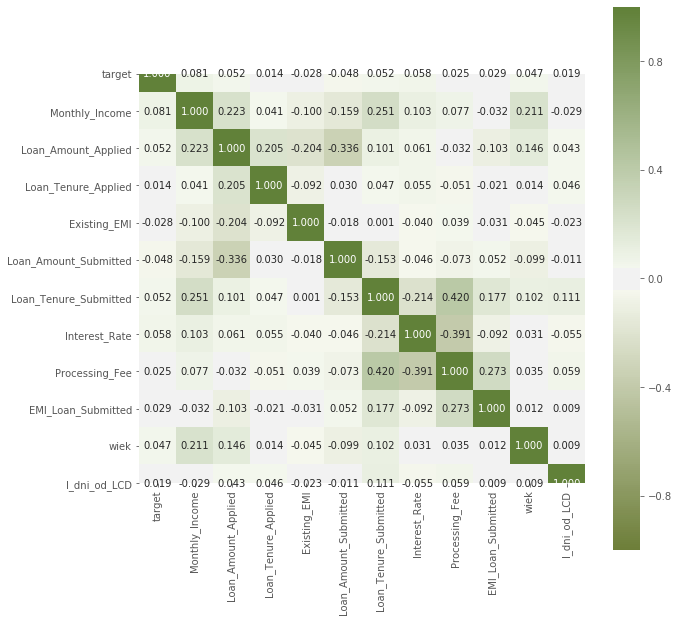

In [31]:
zmienne_kat = [
'target',
'Monthly_Income',
'Loan_Amount_Applied',
'Loan_Tenure_Applied',
'Existing_EMI',
'Loan_Amount_Submitted',
'Loan_Tenure_Submitted',
'Interest_Rate',
'Processing_Fee',
'EMI_Loan_Submitted',
'wiek',
'l_dni_od_LCD'
]
kolumny_do_analizy = X_train[zmienne_kat]
plt.figure(figsize=(10,10))
sns.heatmap(
    kolumny_do_analizy.corr(method='spearman'), 
    vmax=1,
    vmin=-1,
    annot=True,
    square=True,
    cmap = sns.diverging_palette(100, 110, as_cmap=True),
    fmt='.3f'
);

## Zamiana zmiennych ktore zostaly skategoryzowane na zmienne binarne dla kazdej wartosci kategorii

In [32]:
X_train = dummies(X_train,'Monthly_Income')              
X_train = dummies(X_train,'Loan_Amount_Applied')         
X_train = dummies(X_train,'Loan_Tenure_Applied')         
X_train = dummies(X_train,'Existing_EMI')                                      
X_train = dummies(X_train,'Loan_Amount_Submitted')       
X_train = dummies(X_train,'Loan_Tenure_Submitted')       
X_train = dummies(X_train,'Interest_Rate')               
X_train = dummies(X_train,'Processing_Fee')              
X_train = dummies(X_train,'EMI_Loan_Submitted')                                                      
X_train = dummies(X_train,'wiek')                        
X_train = dummies(X_train,'l_dni_od_LCD')  

In [33]:
X_test = dummies(X_test,'Monthly_Income')              
X_test = dummies(X_test,'Loan_Amount_Applied')         
X_test = dummies(X_test,'Loan_Tenure_Applied')         
X_test = dummies(X_test,'Existing_EMI')                                       
X_test = dummies(X_test,'Loan_Amount_Submitted')       
X_test = dummies(X_test,'Loan_Tenure_Submitted')       
X_test = dummies(X_test,'Interest_Rate')               
X_test = dummies(X_test,'Processing_Fee')              
X_test = dummies(X_test,'EMI_Loan_Submitted')                                                      
X_test = dummies(X_test,'wiek')                        
X_test = dummies(X_test,'l_dni_od_LCD') 

## Usuniecie zmiennej celu i nazwy pracodawcy ze wzgledu na nieistotnosc

In [34]:
X_train = X_train.drop(["target"], axis=1)
X_test = X_test.drop(["target"], axis=1)

## Wybor najlepszych zmiennych korzystajac z SelectKBest

In [35]:
bestfeatures=SelectKBest(score_func=chi2,k=10)
fit = bestfeatures.fit(X_train, y_train)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X_train.columns)
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score']
bestf = featureScores.nlargest(20,'Score')

In [36]:
name_bestf = bestf['Specs'].to_list()

In [37]:
name_bestf

['Monthly_Income_18.0',
 'Monthly_Income_3.0',
 'Interest_Rate_16.0',
 'Monthly_Income_13.0',
 'Loan_Amount_Submitted_11.0',
 'Monthly_Income_14.0',
 'Loan_Amount_Submitted_15.0',
 'Existing_EMI_17.0',
 'Interest_Rate_18.0',
 'EMI_Loan_Submitted_15.0',
 'Loan_Tenure_Submitted_4.0',
 'Loan_Amount_Submitted_13.0',
 'Existing_EMI_6.0',
 'EMI_Loan_Submitted_18.0',
 'Salary_Account_nan',
 'Processing_Fee_17.0',
 'wiek_3.0',
 'Mobile_Verified_N',
 'Existing_EMI_3.0',
 'Loan_Amount_Applied_1.0']

## Wybór ze zbioru treningowego/testowego tylko tych zmiennych

In [38]:
X_train_bf = X_train[name_bestf]
X_test_bf = X_test[name_bestf]

## Kod do generowania wykresów i ocen modeli

In [39]:
def wykresy(y__test,model,model_txt):
    scikitplot.metrics.plot_roc(y__test,model)
    plt.show()
    skplt.plot_ks_statistic(y__test,model)
    plt.show()
    scikitplot.metrics.plot_lift_curve(y__test,model)
    plt.show()
    scikitplot.metrics.plot_cumulative_gain(y__test,model)
    plt.show()


def bledy(y__test,model,model_dyscrets,model_txt):
    print('Mean Absolutle Error:', metrics.mean_absolute_error(y__test,model_dyscrets))
    print('Mean Squared Error:', metrics.mean_squared_error(y__test,model_dyscrets))
    print('F1 score:', metrics.f1_score(y__test,model_dyscrets, average='weighted'))
    print('Accuracy:', metrics.accuracy_score(y__test,model_dyscrets))
    print('AUC:', roc_auc_score(y__test,model[:,1]))

    Mean_Absolutle_Error = []
    Mean_quared_Error = []
    F1_score = []
    Accuracy = []
    AUC = []

    Mean_Absolutle_Error.append(metrics.mean_absolute_error(y__test,model_dyscrets))
    Mean_quared_Error.append(metrics.mean_squared_error(y__test,model_dyscrets))
    F1_score.append(metrics.f1_score(y__test,model_dyscrets, average='weighted'))
    Accuracy.append(metrics.accuracy_score(y__test,model_dyscrets))
    AUC.append(roc_auc_score(y__test,model[:,1]))

    d = {'Mean Absolutle Error': Mean_Absolutle_Error, 
         'Mean Squared Error': Mean_quared_Error, 
         'F1 score': F1_score,
         'Accuracy' : Accuracy,
         'AUC': AUC
        }
    global model_stat
    model_stat = pd.DataFrame(data=d)
    model_stat.insert(loc=0, column='Metoda', value=[model_txt])

    
def info_modele(X__train,y__test,model,model_dyscrets,model_txt):
    wykresy(y__test,model,model_txt)
    bledy(y__test,model,model_dyscrets,model_txt)

## Model gradient boosting z GridSearchCV

In [40]:
n_estimators=[2,4]
max_depth=[3,5,7]
learning_rate=[0.1,0.2,0.3,1]
min_samples_split=[50]
min_samples_leaf=[8]
max_features=[5,6,7,10]
subsample=[0.9]
random_state=[10]
param_grid=dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,min_samples_split=min_samples_split,
               min_samples_leaf=min_samples_leaf,max_features=max_features,subsample=subsample,random_state=random_state)

gbr_grid=ensemble.GradientBoostingClassifier()
grid=GridSearchCV(estimator=gbr_grid,param_grid=param_grid)
grid_result_gbr=grid.fit(X_train_bf,y_train)
y_gbr_grid=grid_result_gbr.predict_proba(X_test_bf)
y_gbr_dyscrets_grid=grid_result_gbr.predict(X_test_bf)

## Wygenerowanie wykresów ocen i błędów modelu

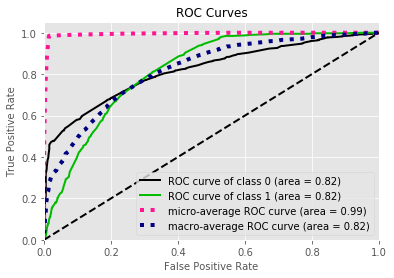

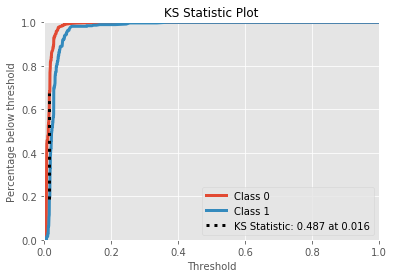

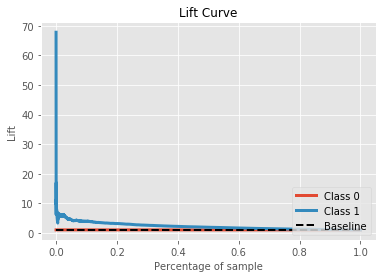

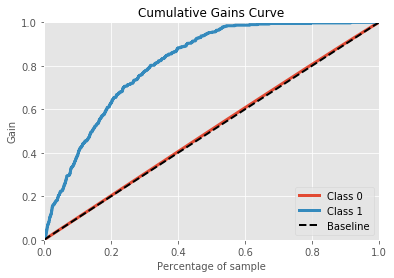

Mean Absolutle Error: 0.014747567608978778
Mean Squared Error: 0.014747567608978778
F1 score: 0.9779334251849213
Accuracy: 0.9852524323910212
AUC: 0.819536363484888


In [65]:
info_modele(X_train,y_test,y_gbr_grid,y_gbr_dyscrets_grid,'GradientBoostingClassifier + GridSearchCV + SelectKBest')

## Rekord do porównania modeli

In [66]:
model_stat_gbr = model_stat
model_stat_gbr

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,GradientBoostingClassifier + GridSearchCV + Se...,0.014748,0.014748,0.977933,0.985252,0.819536


## Model drzewa decyzyjnego z GridSearchCV

In [43]:
min_samples_leaf=[5,25,30,40,50,60,70,80,90,100]
max_depth=[3,4,5,6,7]
criterion=['gini','entropy']
param_grid=dict(min_samples_leaf=min_samples_leaf,max_depth=max_depth,criterion=criterion)

clf_grid=tree.DecisionTreeClassifier()
grid=GridSearchCV(estimator=clf_grid,param_grid=param_grid)
grid_result_clf=grid.fit(X_train,y_train)
y_clf_grid=grid_result_clf.predict_proba(X_test)
y_clf_dyscrets_grid=grid_result_clf.predict(X_test)

## Wygenerowanie wykresów ocen i błędów modelu

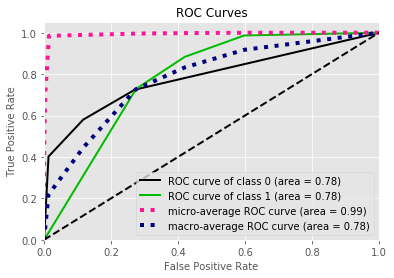

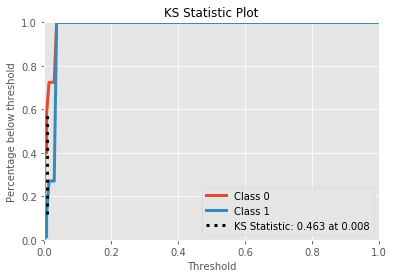

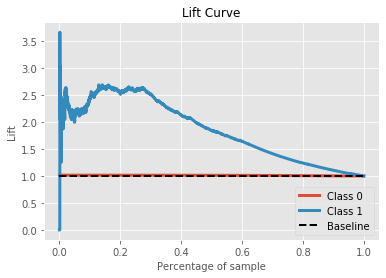

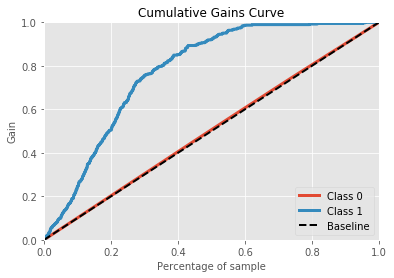

Mean Absolutle Error: 0.014747567608978778
Mean Squared Error: 0.014747567608978778
F1 score: 0.9779334251849213
Accuracy: 0.9852524323910212
AUC: 0.7827486459343697


In [67]:
info_modele(X_train,y_test,y_clf_grid,y_clf_dyscrets_grid,'DecisionTreeClassifier + GridSearchCV + SelectKBest')

## Rekord do porównania modeli

In [71]:
model_stat_clf = model_stat
model_stat_clf

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508


## Model regresji logistycznej z GridSearchCV

In [46]:
C=np.logspace(-3,3,7)
penalty=["l1","l2"]
param_grid=dict(C=C,penalty=penalty)

lr_grid=LogisticRegression()
grid=GridSearchCV(estimator=lr_grid,param_grid=param_grid,cv=10)
grid_result_lr=grid.fit(X_train, y_train)
y_lr_grid=grid_result_lr.predict_proba(X_test)
y_lr_dyscrets_grid=grid_result_lr.predict(X_test)

## Wygenerowanie wykresów ocen i błędów modelu

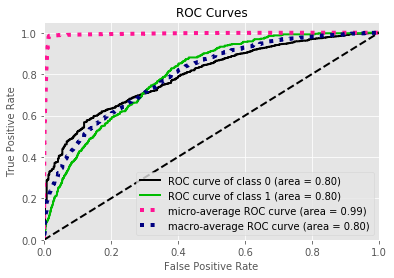

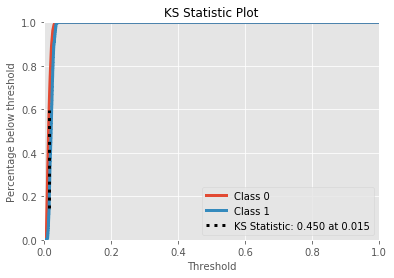

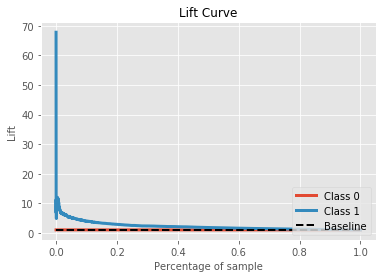

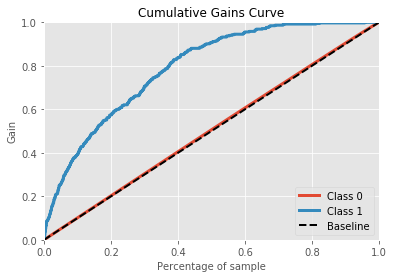

Mean Absolutle Error: 0.014747567608978778
Mean Squared Error: 0.014747567608978778
F1 score: 0.9779334251849213
Accuracy: 0.9852524323910212
AUC: 0.7955081930627205


In [68]:
info_modele(X_train,y_test,y_lr_grid,y_lr_dyscrets_grid,'LogisticRegression + GridSearchCV + SelectKBest')

## Rekord do porównania modeli

In [69]:
model_stat_lr = model_stat
model_stat_lr

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508


## Porównanie modeli przy wykorzystaniu trzech algorytmów i GridSearchCV

In [72]:
Porownanie_3_modeli = pd.concat([model_stat_gbr,model_stat_clf,model_stat_lr])
Porownanie_3_modeli

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,GradientBoostingClassifier + GridSearchCV + Se...,0.014748,0.014748,0.977933,0.985252,0.819536
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508





# Drugie podejscie modelowanie z wykorzystaniem Pipline i GridSearchCV

In [50]:
XX = df  
yy = df.target

## Zamiana zmiennych kategorycznych na zmienne binarne dla kazdej wartosci kategorii

In [51]:
XX = dummies(XX,'Gender')                  
XX = dummies(XX,'City')                                   
XX = dummies(XX,'Salary_Account')           
XX = dummies(XX,'Mobile_Verified')                       
XX = dummies(XX,'Filled_Form')                 
XX = dummies(XX,'Device_Type')                                       
XX = dummies(XX,'Source')                                                                  

## Podział na zbior uczacy i walidujacy

In [52]:
from sklearn.model_selection import train_test_split
XX_train, XX_test , yy_train, yy_test = train_test_split(XX,yy,test_size=0.30,random_state=1234)

## Imputacja zmiennych numerycznych w zbiorze uczacym i tastowym srednia ze zbioru uczacego

In [53]:
imputacja_avg(XX_train,XX_test,'Monthly_Income')
imputacja_avg(XX_train,XX_test,'Loan_Amount_Applied')
imputacja_avg(XX_train,XX_test,'Loan_Tenure_Applied')
imputacja_avg(XX_train,XX_test,'Existing_EMI')
imputacja_avg(XX_train,XX_test,'Loan_Amount_Submitted')
imputacja_avg(XX_train,XX_test,'Loan_Tenure_Submitted')
imputacja_avg(XX_train,XX_test,'Interest_Rate')
imputacja_avg(XX_train,XX_test,'Processing_Fee')
imputacja_avg(XX_train,XX_test,'EMI_Loan_Submitted')
imputacja_avg(XX_train,XX_test,'wiek')
imputacja_avg(XX_train,XX_test,'l_dni_od_LCD')

## Usuniecie zmiennej celu i nazwy pracodawcy

In [54]:
XX_train = XX_train.drop(["target"], axis=1)
XX_train = XX_train.drop(["Employer_Name"], axis=1)
XX_test = XX_test.drop(["target"], axis=1)
XX_test = XX_test.drop(["Employer_Name"], axis=1)

## Model gradient boosting z GridSearchCV i Pipeline

In [55]:
pipe = Pipeline([("scale",StandardScaler()),("gbr",ensemble.GradientBoostingClassifier())])

n_estimators=[2,4]
max_depth=[3,5,7]
learning_rate=[0.1,0.2,0.3,1]
min_samples_split=[50]
min_samples_leaf=[8]
max_features=[5,6,7,10]
subsample=[0.9]
random_state=[10]

param_grid=dict(gbr__n_estimators=n_estimators,gbr__max_depth=max_depth,gbr__learning_rate=learning_rate,gbr__min_samples_split=min_samples_split,
               gbr__min_samples_leaf=min_samples_leaf,gbr__max_features=max_features,gbr__subsample=subsample,gbr__random_state=random_state)


grid_result_pipe_gbr = GridSearchCV(pipe,param_grid,cv = 5)
grid_result_pipe_gbr.fit(XX_train,yy_train)

y_gbr_grid_pipe=grid_result_pipe_gbr.predict_proba(XX_test)
y_gbr_dyscrets_grid_pipe=grid_result_pipe_gbr.predict(XX_test)

## Wygenerowanie wykresów ocen i błędów modelu

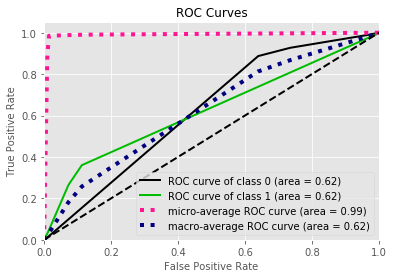

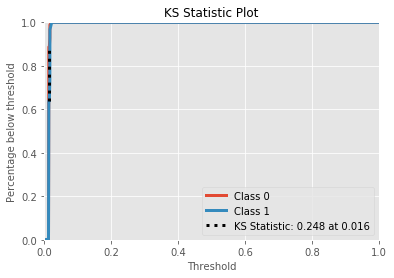

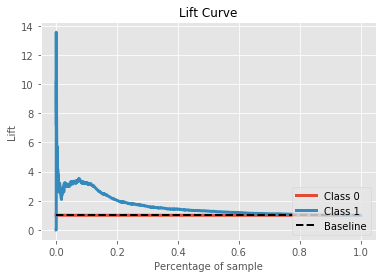

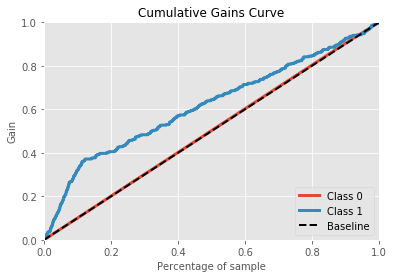

Mean Absolutle Error: 0.014747567608978778
Mean Squared Error: 0.014747567608978778
F1 score: 0.9779334251849213
Accuracy: 0.9852524323910212
AUC: 0.6246034242574035


In [73]:
info_modele(XX_train,yy_test,y_gbr_grid_pipe,y_gbr_dyscrets_grid_pipe,'GradientBoostingClassifier + GridSearchCV + Pipeline')

## Rekord do porownania modeli

In [74]:
model_stat_pgbr = model_stat
model_stat_pgbr

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,GradientBoostingClassifier + GridSearchCV + Pi...,0.014748,0.014748,0.977933,0.985252,0.624603


## Pipline dla drzewa decyzyjnego

In [58]:
pipe = Pipeline([("scale",StandardScaler()),("clf",tree.DecisionTreeClassifier())])

min_samples_leaf=[5,25,30,40,50,60,70,80,90,100]
max_depth=[3,4,5,6,7]
criterion=['gini','entropy']

param_grid=dict(clf__min_samples_leaf=min_samples_leaf,clf__max_depth=max_depth,clf__criterion=criterion)

grid_result_pipe_clf = GridSearchCV(pipe,param_grid,cv = 5)
grid_result_pipe_clf.fit(XX_train,yy_train)

y_clf_grid_pipe=grid_result_pipe_clf.predict_proba(XX_test)
y_clf_dyscrets_grid_pipe=grid_result_pipe_clf.predict(XX_test)

## Wygenerowanie wykresów ocen i błędów modelu

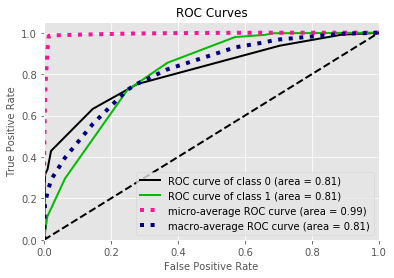

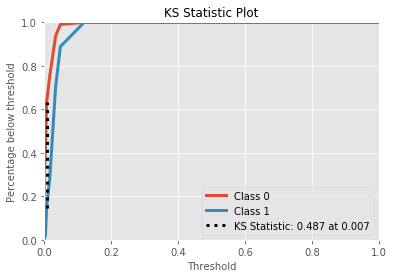

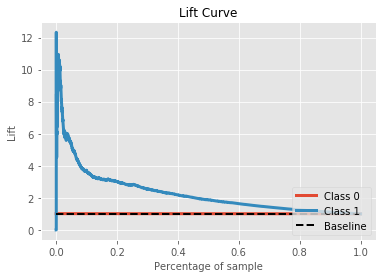

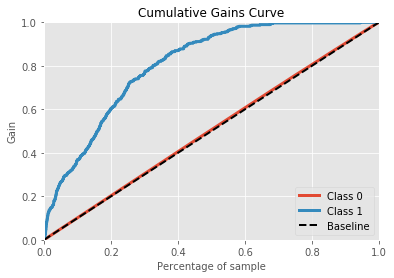

Mean Absolutle Error: 0.014747567608978778
Mean Squared Error: 0.014747567608978778
F1 score: 0.9779334251849213
Accuracy: 0.9852524323910212
AUC: 0.8134574457073581


In [75]:
info_modele(XX_train,yy_test,y_clf_grid_pipe,y_clf_dyscrets_grid_pipe,'DecisionTreeClassifier + GridSearchCV + Pipeline')

## Rekord do porownania modeli

In [76]:
model_stat_pclf = model_stat
model_stat_pclf

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,DecisionTreeClassifier + GridSearchCV + Pipeline,0.014748,0.014748,0.977933,0.985252,0.813457


## Pipline dla regresji logistycznej

In [61]:
pipe = Pipeline([("scale",StandardScaler()),("lr",LogisticRegression())])

C=np.logspace(-3,3,7)
penalty=["l1","l2"]
param_grid=dict(lr__C=C,lr__penalty=penalty)

grid_result_pipe_lr = GridSearchCV(pipe,param_grid,cv = 5)
grid_result_pipe_lr.fit(XX_train,yy_train)

y_lr_grid_pipe=grid_result_pipe_lr.predict_proba(XX_test)
y_lr_dyscrets_grid_pipe=grid_result_pipe_lr.predict(XX_test)

## Wygenerowanie wykresów ocen i błędów modelu

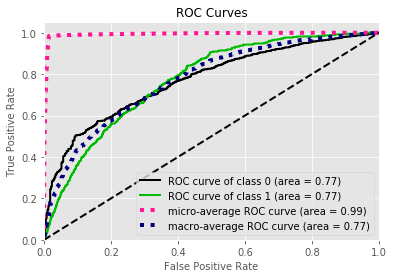

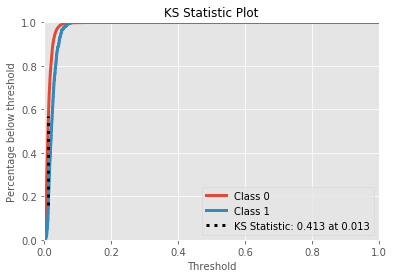

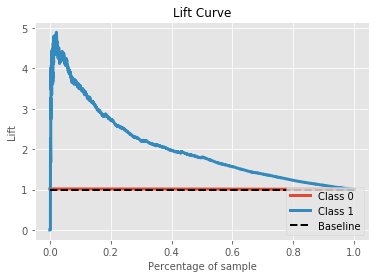

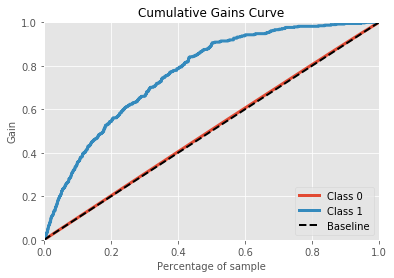

Mean Absolutle Error: 0.014862483720217574
Mean Squared Error: 0.014862483720217574
F1 score: 0.9778759669740769
Accuracy: 0.9851375162797824
AUC: 0.7709979767909085


In [77]:
info_modele(XX_train,yy_test,y_lr_grid_pipe,y_lr_dyscrets_grid_pipe,'LogisticRegression + GridSearchCV + Pipeline')

## Rekord do porownania modeli

In [78]:
model_stat_plr = model_stat
model_stat_plr

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,LogisticRegression + GridSearchCV + Pipeline,0.014862,0.014862,0.977876,0.985138,0.770998


## Pipline dla lasu losowego

In [84]:
pipe = Pipeline([("scale",StandardScaler()),("rf",RandomForestClassifier())])

min_samples_leaf=[5,25,30]
max_depth=[3,4,5]
criterion=['gini','entropy']

param_grid=dict(rf__min_samples_leaf=min_samples_leaf,rf__max_depth=max_depth,rf__criterion=criterion)

grid_result_pipe_rf = GridSearchCV(pipe,param_grid,cv = 5)
grid_result_pipe_rf.fit(XX_train,yy_train)

y_rf_grid_pipe=grid_result_pipe_lr.predict_proba(XX_test)
y_rf_dyscrets_grid_pipe=grid_result_pipe_lr.predict(XX_test)

## Wygenerowanie wykresów ocen i błędów modelu

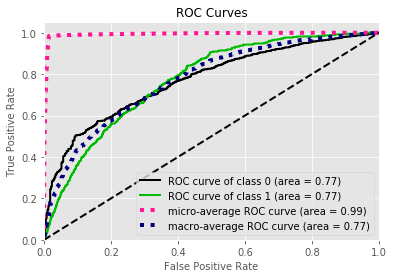

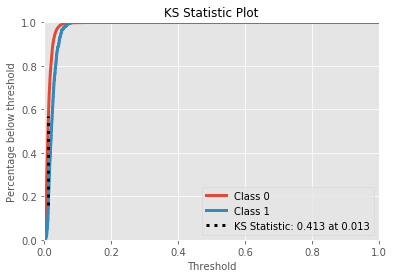

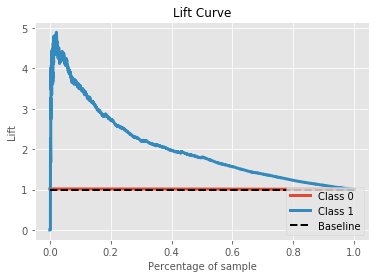

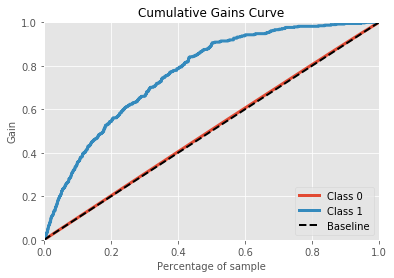

Mean Absolutle Error: 0.014862483720217574
Mean Squared Error: 0.014862483720217574
F1 score: 0.9778759669740769
Accuracy: 0.9851375162797824
AUC: 0.7709979767909085


In [85]:
info_modele(XX_train,yy_test,y_rf_grid_pipe,y_rf_dyscrets_grid_pipe,'RandomForestClassifier + GridSearchCV + Pipeline')

## Rekord do porownania modeli

In [86]:
model_stat_prf = model_stat
model_stat_prf

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,RandomForestClassifier + GridSearchCV + Pipeline,0.014862,0.014862,0.977876,0.985138,0.770998


## Porównanie wszystkich modeli

In [87]:
Porownanie_6_modeli = pd.concat([model_stat_gbr,model_stat_clf,model_stat_lr,model_stat_pgbr,model_stat_pclf,model_stat_plr,model_stat_prf])
Porownanie_6_modeli

,Metoda,Mean Absolutle Error,Mean Squared Error,F1 score,Accuracy,AUC
0,GradientBoostingClassifier + GridSearchCV + Se...,0.014748,0.014748,0.977933,0.985252,0.819536
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508
0,LogisticRegression + GridSearchCV + SelectKBest,0.014748,0.014748,0.977933,0.985252,0.795508
0,GradientBoostingClassifier + GridSearchCV + Pi...,0.014748,0.014748,0.977933,0.985252,0.624603
0,DecisionTreeClassifier + GridSearchCV + Pipeline,0.014748,0.014748,0.977933,0.985252,0.813457
0,LogisticRegression + GridSearchCV + Pipeline,0.014862,0.014862,0.977876,0.985138,0.770998
0,RandomForestClassifier + GridSearchCV + Pipeline,0.014862,0.014862,0.977876,0.985138,0.770998


Analizujac wykresy statystyki KS oraz miare AUC najlepsze modele to gbr oraz pipe clf